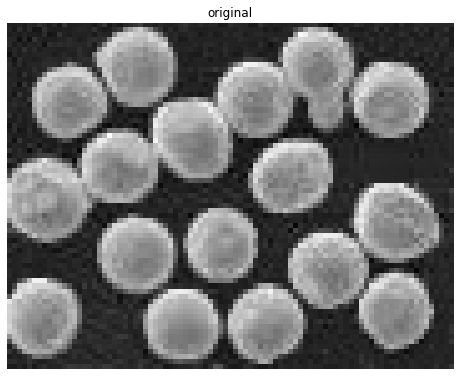

In [41]:
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plot

X = np.array([[1, 1], [2, 1], [1, 0],
               [4, 7], [3, 5], [3, 6]])

plot.scatter(
    X[:, 0],
    X[:, 1],
)
plot.show()


c:\users\toliak\.virtualenvs\particle-counter-lttw4zry\lib\site-packages\skimage\filters\rank\generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


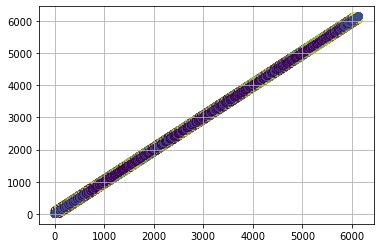

In [42]:
clustering = SpectralClustering(
    n_clusters=2,
    random_state=0,
    eigen_solver='lobpcg',
    n_jobs=-1,
).fit(X)

plot.scatter(
    X[:, 0],
    X[:, 1],
    c=clustering.labels_
)
plot.show()



